In [1]:
import torch
# import random
# import urllib.request
# import imageio as imio
from einops import rearrange
import matplotlib.pyplot as plt
from IPython.display import clear_output#, HTML, display
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0' #! [COMP6411] CHANGE IT
import sys
sys.path.append('..')

from models.model_utils import TrajectorySampler
from builders.builders import build_dataloader
from utils.utils import instantiate_from_config
# from notebooks.walkthrough_utils import get_smooth_trajectory
from utils.camera_trajectory import rotate_n, go_forward, go_backward

## Load Pre-trained Model and Dataloader

In [2]:
# download pretrained model (takes anywhere from a few seconds to a few minutes depending on internet speed)
model_url = '/disk2/kaho/projects_on_disk2/nerf/v1ml-gsn_s8_densedata_vKEmat/logs/checkpoints/gsn-model-best-fid.ckpt' #! [COMP6411] CHANGE IT
checkpoint_filename = 'gsn-model-best-fid.ckpt' #! [COMP6411] CHANGE IT

# model_url = 'https://docs-assets.developer.apple.com/ml-research/models/gsn/vizdoom_64x64.ckpt'
# checkpoint_filename = 'vizdoom_64x64.ckpt'
# urllib.request.urlretrieve(model_url, checkpoint_filename)

In [3]:
# Note: adjust the data path here if data is in a different location than default
data_path = '/disk2/kaho/projects_on_disk2/nerf/v1ml-gsn_s8_densedata_vKEmat/data/new_Town02_left25resize512' #! [COMP6411] CHANGE IT to your data folder
checkpoint = torch.load('/disk2/kaho/projects_on_disk2/nerf/v1ml-gsn_s8_densedata_vKEmat/logs/checkpoints/gsn-model-best-fid.ckpt') #! [COMP6411] CHANGE IT

# data_path = '/disk2/kaho/projects_on_disk2/nerf/ml-gsn_s8/data/vizdoom_data_iss'
# checkpoint = torch.load(checkpoint_filename)

state_dict = checkpoint['state_dict']

# get rid of all the inception params which are leftover from FID metric
keys_for_deletion = []
for key in state_dict.keys():
    if 'fid' in key:
        keys_for_deletion.append(key)
for key in keys_for_deletion:
    del state_dict[key]

opt = checkpoint['opt']
opt.data_config.data_dir = data_path

In [4]:
# create dataloader
data_module = build_dataloader(opt.data_config, verbose=False)

# collect a set of real trajectories from the dataset
real_Rts = data_module.train_loader.dataset.get_trajectory_Rt()
trajectory_sampler = TrajectorySampler(real_Rts=real_Rts, mode=opt.model_config.params.trajectory_mode)

# initialize model and load state
gsn = instantiate_from_config(opt.model_config).cuda().eval()
gsn.set_trajectory_sampler(trajectory_sampler=trajectory_sampler)
gsn.load_state_dict(state_dict, strict=True)

# increase nerf_out_res after loading model to generate higher res samples (i.e., implicit upsampling)
gsn.generator_config.params.nerf_out_res *= 2 #! [COMP6411] CHANGE IT to ==>>> 1 if 2 does not work <===
# trade render speed for memory by rendering smaller patches at a time
gsn.patch_size = 32

# load a batch of data so that we can use the camera parameters
real_data = next(iter(data_module.train_dataloader()))

load() missing 1 required positional argument: 'sources'
There was something wrong with the CUDA kernels
Reverting to native PyTorch implementation


## Interactive Walkthrough
Use wasd to explore the scene. Enter 'q' to stop exploring.

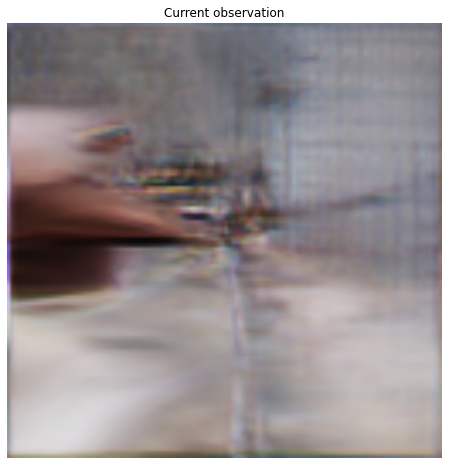

a/w/d/sq


In [5]:
device = 'cuda'
z_dim = opt.model_config.params.decoder_config.params.z_dim
z = torch.randn(1, z_dim, device=device)

# print(real_data['K'])
K_current = torch.unsqueeze(real_data['K'][0],0).to(device) #! [COMP6411] CHANGE IT ===> change K_current to this line
Rt_current=torch.unsqueeze(real_data['Rt'][0], 0).to(device)#! [COMP6411] CHANGE IT ===> change R_current to this line

# intrinsic camera matrix from real data
# initialize extrinsic camera matrix at the center of the scene
# K_current = real_data['K'].to(device)
# Rt_current = torch.eye(4, device=device).view(1, 1, 4, 4)

trajectory = {'rgb': [], 'depth': [], 'Rt': [], 'K': []}

while True:
    camera_params = {'K': K_current, 'Rt': Rt_current}
    
    with torch.no_grad():
        fake_rgb, fake_depth, Rt, K = gsn(z, camera_params=camera_params)
    
    trajectory['rgb'].append(fake_rgb)
    trajectory['depth'].append(fake_depth)
    trajectory['Rt'].append(Rt)
    trajectory['K'].append(K)
    
    rgb_current = rearrange(fake_rgb, 'b t c h w -> (b t h) w c').cpu()
    
    clear_output()
    fig = plt.figure(figsize = (8, 8)) 
    ax = fig.add_subplot(111)
    ax.imshow(rgb_current, interpolation='bilinear')
    ax.set_title('Current observation');
    plt.axis('off')
    plt.show()

    action = input("a/w/d/s")
    if action == 'a':
        # Turn left
        Rt = rotate_n(n=-30.0).to(device)
        Rt_current = torch.bmm(Rt.unsqueeze(0), Rt_current[0]).unsqueeze(0)
    if action == 'd':
        # Turn right
        Rt = rotate_n(n=30.0).to(device)
        Rt_current = torch.bmm(Rt.unsqueeze(0), Rt_current[0]).unsqueeze(0)
    if action == 'w':
        # Go forward
        Rt_current = go_forward(Rt_current, step=opt.model_config.params.voxel_size / 10)  #! [COMP6411] CHANGE IT ===> change 10 to 0.6 / 1 / 5, the setting that you used
    if action == 's':
        # Go backward
        Rt_current = go_backward(Rt_current, step=opt.model_config.params.voxel_size / 10)  #! [COMP6411] CHANGE IT ===> change 10 to 0.6 / 1 / 5, the setting that you used
    if action == 'q':
        break
        
for key in trajectory.keys():
    trajectory[key] = torch.cat(trajectory[key], dim=1)

## Generate Animation
Fit a spline to the camera trajectory and uniformly render frames along it to produce a smooth animation.

In [ ]:
# jitter camera pose a tiny amount to make sure each pose is unique
# (to avoid problems with trajectory smoothing)
trajectory['Rt'] = trajectory['Rt'] + torch.rand_like(trajectory['Rt']) * 1e-5

# fit a smooth spline to the trajectory keypoints
n_keypoints = len(trajectory['Rt'][0])
new_Rts = get_smooth_trajectory(Rt=trajectory['Rt'][0], n_frames=5 * n_keypoints, subsample=3)
n_steps = len(new_Rts)

# render frames along new smooth trajectory
resampled_trajectory = {'rgb': [], 'depth': [], 'Rt': [], 'K': []}
for i in range(n_steps):
    if i % 10 == 0:
        print('Rendering frame {}/{}'.format(i, n_steps))
    
    camera_params = {'K': K_current[:1, :1], 'Rt': new_Rts[i:i+1].to(device)}
    
    with torch.no_grad():
        fake_rgb, fake_depth, Rt, K = gsn(z, camera_params=camera_params)

    resampled_trajectory['rgb'].append(fake_rgb)
    resampled_trajectory['depth'].append(fake_depth)
    resampled_trajectory['Rt'].append(Rt)
    resampled_trajectory['K'].append(K)

for key in resampled_trajectory.keys():
    resampled_trajectory[key] = torch.cat(resampled_trajectory[key], dim=1)

imgs = []
for i in range(n_steps):
    im = resampled_trajectory['rgb'][0, i].permute(1, 2, 0).detach().cpu()
    imgs.append((im * 255).byte())

# save gif with random unique name
n = ''.join(random.choice('0123456789ABCDEF') for i in range(5))
animation_filename = 'camera_trajectory_{}.gif'.format(n)
print('Saving animation to {}\n'.format(animation_filename))
imio.mimsave(animation_filename, imgs, fps=30)

display(HTML('<img src={}>'.format(animation_filename)))